<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/multicolTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.special import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor

%config InlineBackend.figure_format = 'retina'

In [2]:
# Import macroeconomics data (Independence variables)
mev = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv')

# Select variables for linear regression model
selectedVars = [
                'GDP_C_lg12',
                'MPI_C_lg12',
                'RSI_C_lg12',
                'PCI_C_lg12',
                'OP_C'
]
mev = mev[selectedVars]
mev.head(5)

,GDP_C_lg12,MPI_C_lg12,RSI_C_lg12,PCI_C_lg12,OP_C
0,0.125214,0.239164,0.165824,0.081950,-0.050376
1,0.086355,0.119307,0.043697,0.029768,-0.068460
2,0.052505,0.143477,0.080085,0.056690,-0.016987
3,0.032748,0.089870,0.073149,0.041751,0.046622
4,0.026525,0.046398,0.021928,0.021510,0.062547


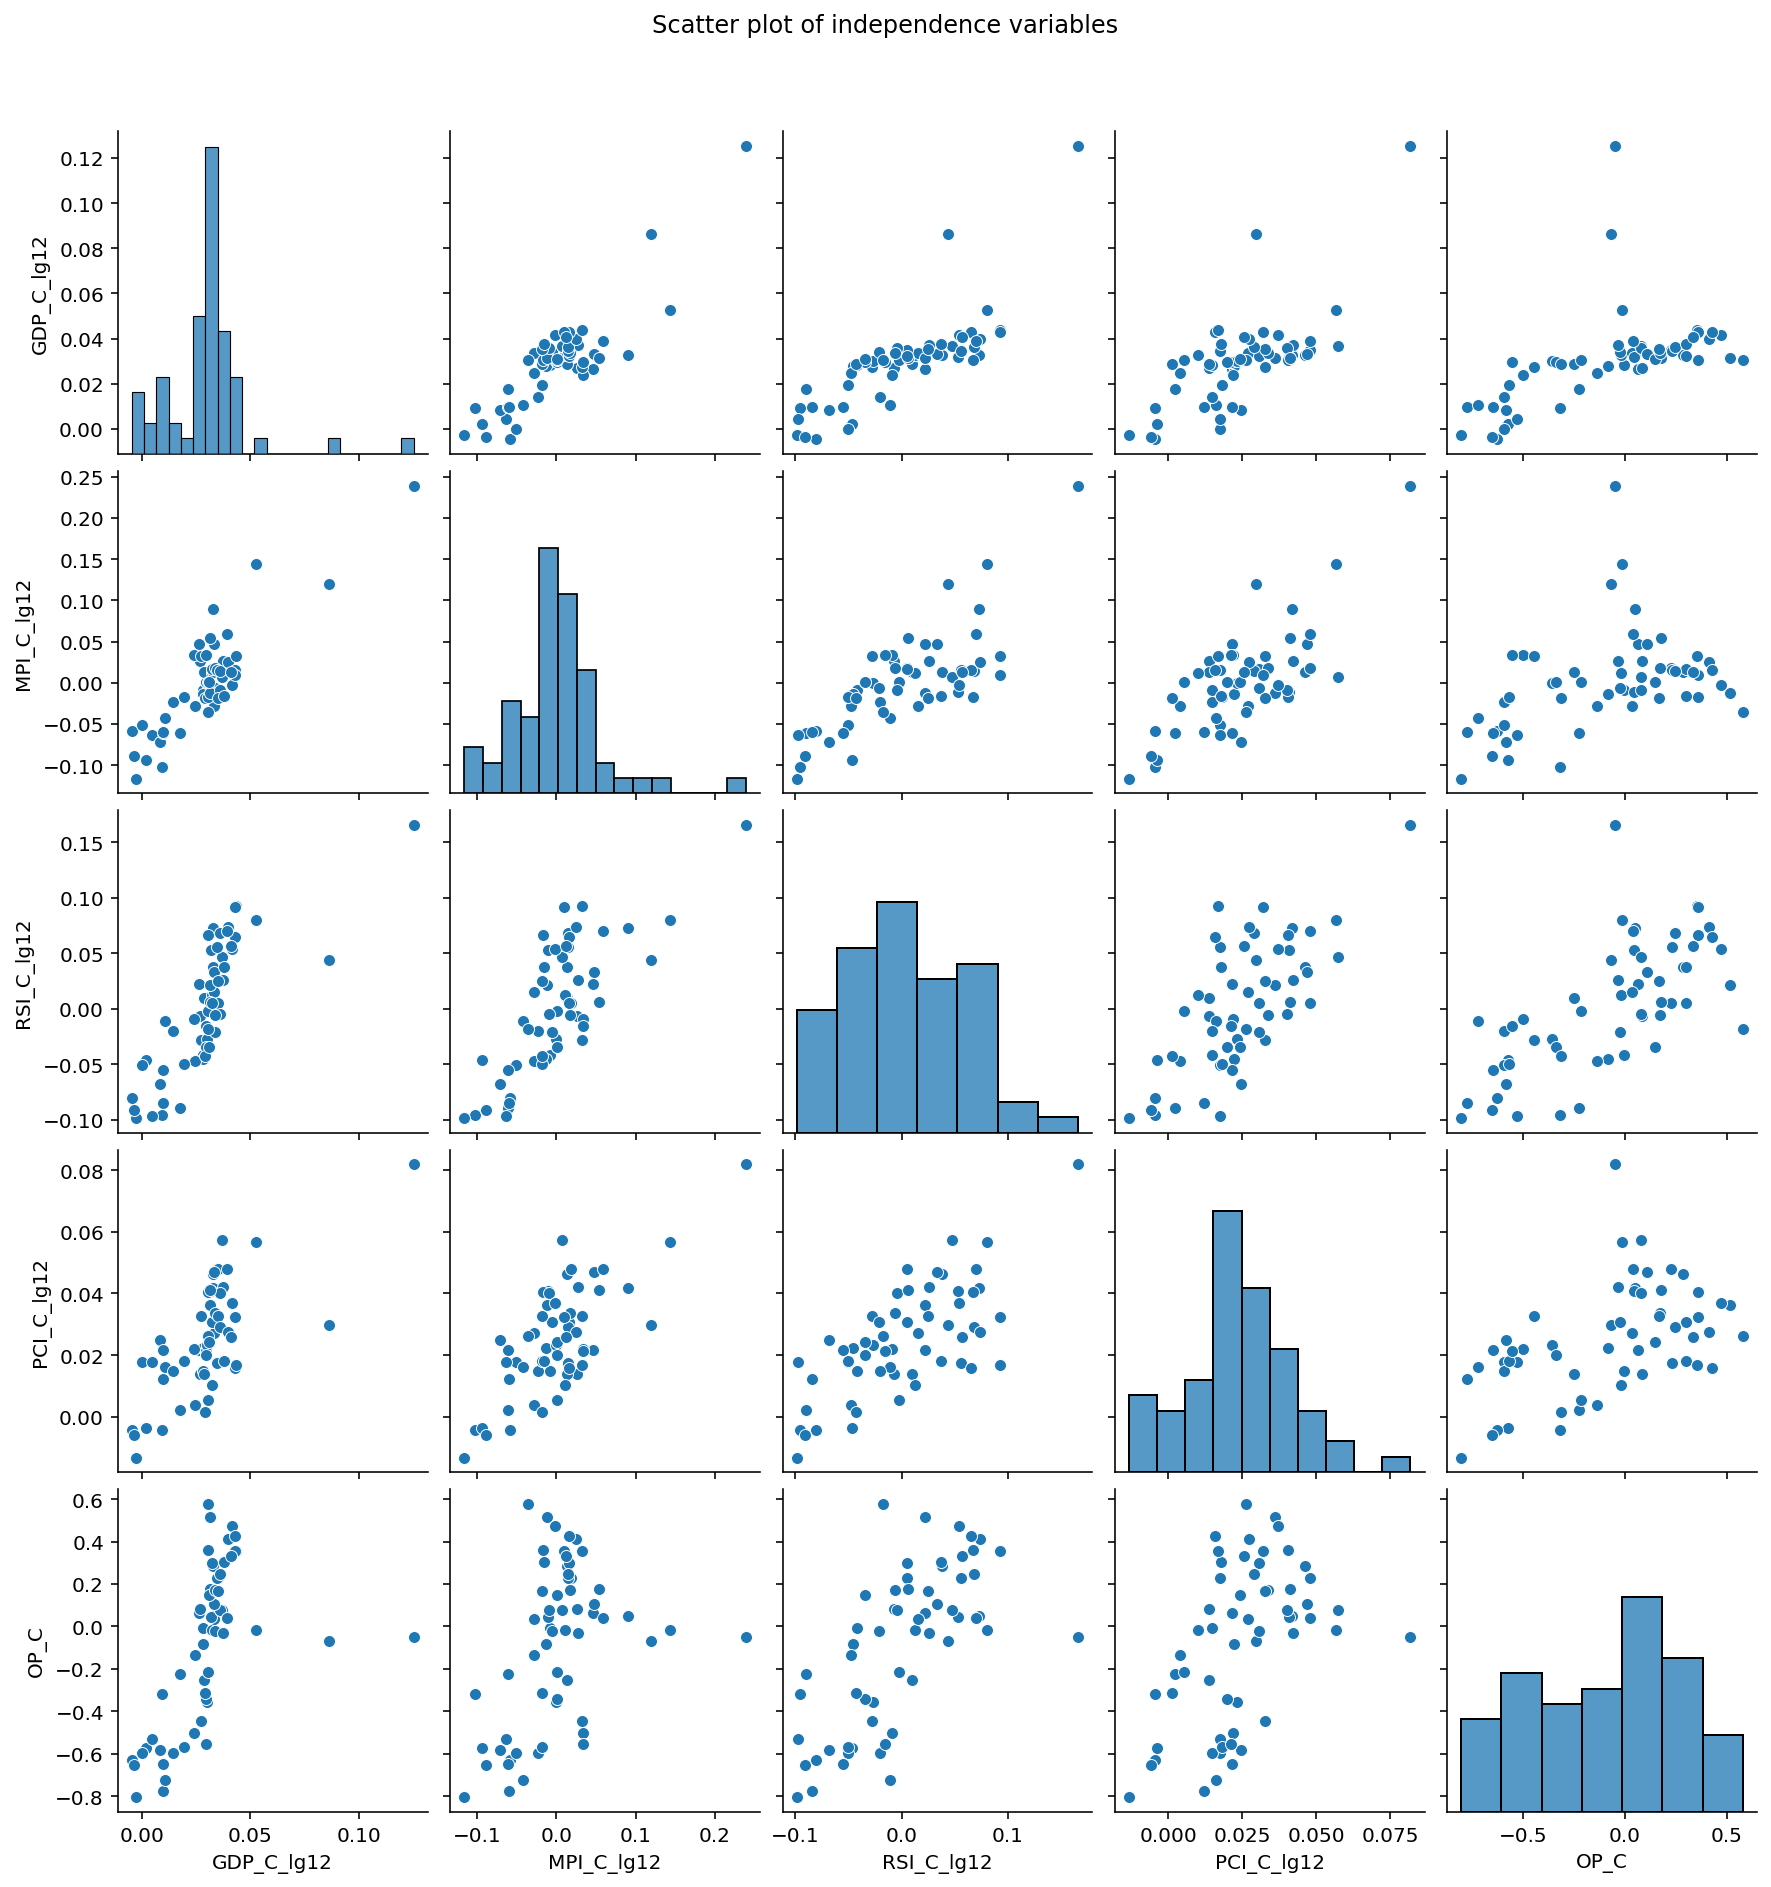

In [3]:
# Scatter matrix plot
ax = sns.pairplot(mev, kind = 'scatter')
ax.fig.suptitle('Scatter plot of independence variables',  y = 1.05)
plt.show()

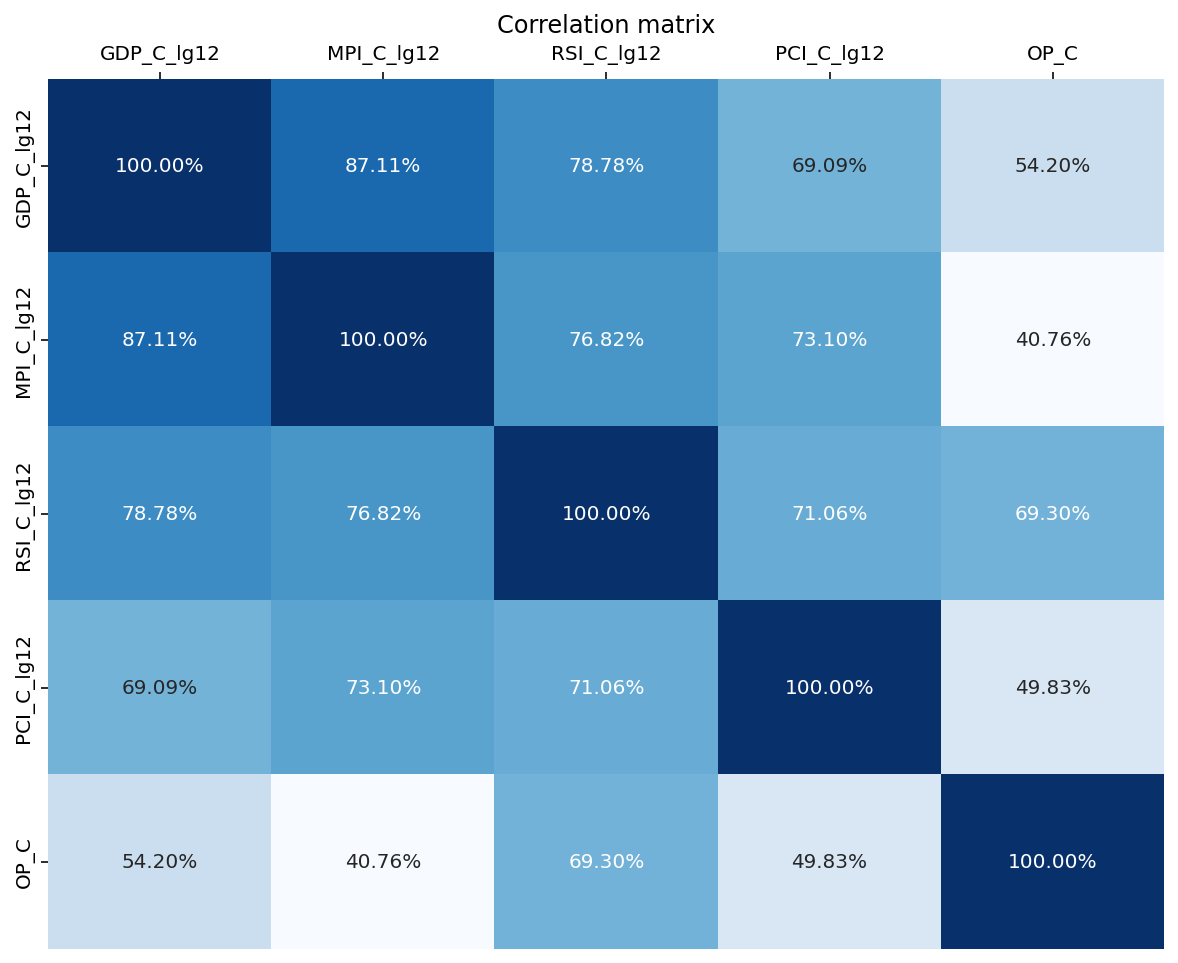

In [4]:
# Correlation matrix
XCorr = mev.corr()

# Plot
plt.figure(figsize = (10, 8))
plt.title('Correlation matrix')
ax = sns.heatmap(
    XCorr,
    annot = True,
    fmt = '.2%',
    xticklabels = True,
    yticklabels = True,
    cmap = plt.cm.Blues,
    cbar = False
)
ax.xaxis.tick_top() #x axis on top
ax.xaxis.set_label_position('top')
plt.show()

In [5]:
# VIF
VIF = [
       variance_inflation_factor(mev.values, var) for var in range(len(mev.columns))
]

# To DataFrame
VIF = pd.DataFrame(
    {
        'Variables': mev.columns,
        'VIF': VIF
    }
)

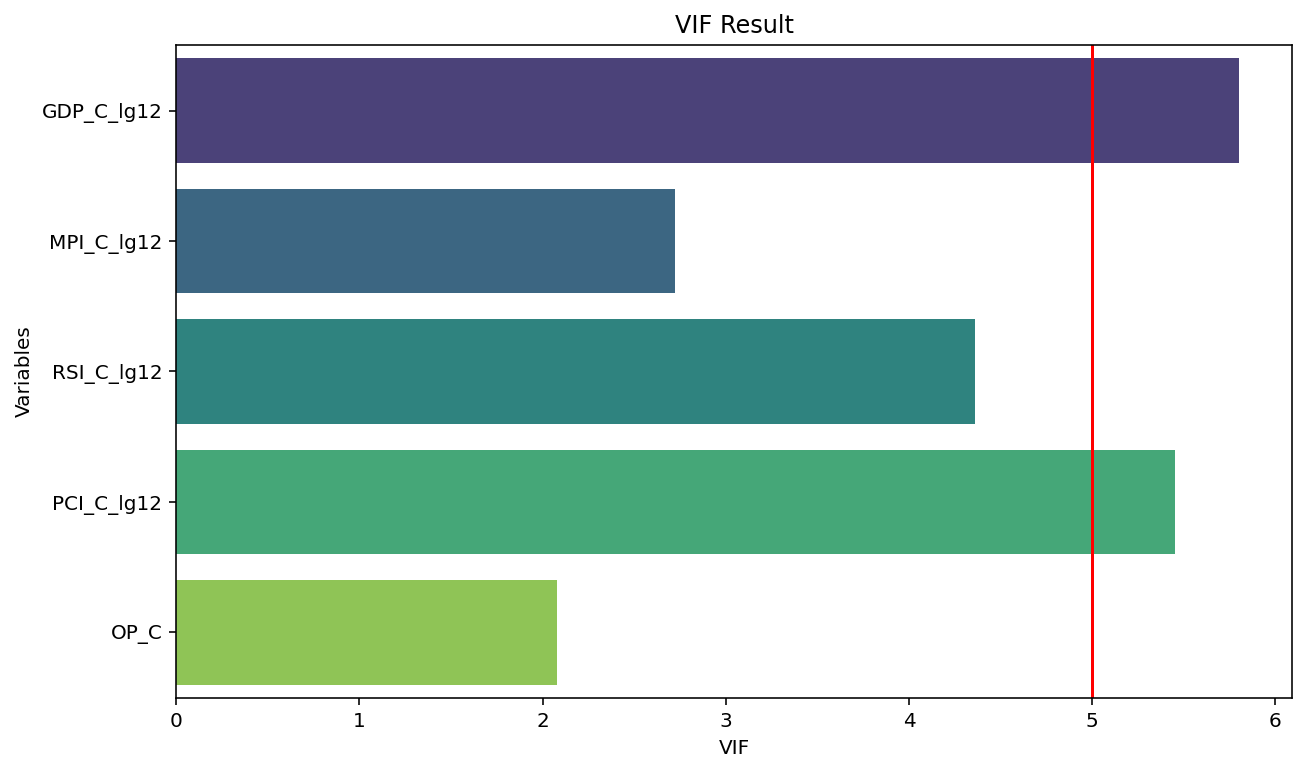

In [6]:
# Define plot function
def plotVIF(data):
  with plt.style.context('seaborn-deep'):
    plt.figure(figsize = (10, 6))
    plt.title('VIF Result')
    sns.barplot(
        x = 'VIF',
        y = 'Variables',
        data = data,
        palette = 'viridis'
    )
    plt.axvline(x = 5, c = 'red')
  return plt.show()

# Plot
plotVIF(VIF)

In [7]:
# Import dependence variable
odr = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/monthlyODR.csv')
odr = odr.query("Segment == 'CU'") #Select only one segment
odr = odr.eval("ODR = Bad / N") #ODR Calculation (12-Motnhs bad rate)

# Dependence variable transformation
# Logit transformation
y = logit(odr['ODR'])

X = sm.add_constant(mev) #Add intercept

# Linear regression model
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ODR   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     38.28
Date:                Wed, 19 Jan 2022   Prob (F-statistic):           1.99e-16
Time:                        08:03:58   Log-Likelihood:                 111.57
No. Observations:                  59   AIC:                            -211.1
Df Residuals:                      53   BIC:                            -198.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9786      0.022   -138.015      0.0

In [8]:
# Drop 'PCI_C_lg12'
X = X.drop(['PCI_C_lg12'], axis = 1)

# New fitting
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ODR   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     48.60
Date:                Wed, 19 Jan 2022   Prob (F-statistic):           2.82e-17
Time:                        08:03:58   Log-Likelihood:                 111.50
No. Observations:                  59   AIC:                            -213.0
Df Residuals:                      54   BIC:                            -202.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9746      0.018   -163.436      0.0

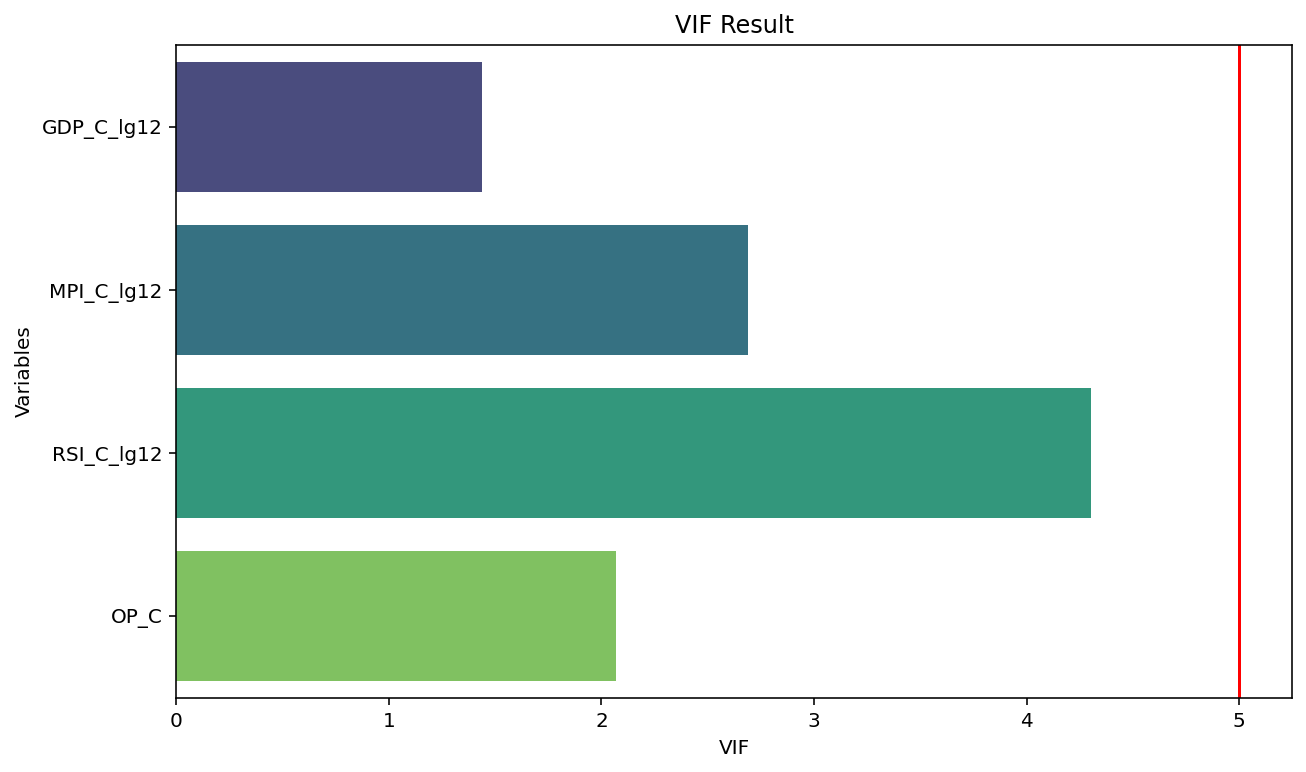

In [9]:
# New VIF
newVIF = [
       variance_inflation_factor(X.iloc[:, 1:].values, var) for var in range(len(X.columns) - 1) #- 1 for Ignore intercept
]

# To DataFrame
newVIF = pd.DataFrame(
    {
        'Variables': X.columns[1:],
        'VIF': newVIF
    }
)

# Plot
plotVIF(newVIF)